# Nested rejection sampling

This example demonstrates how to use nested rejection sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data. For a tutorial on nested sampling, see: [INSERT LINK to NESTED SAMPLING TUTORIAL NOTEBOOK].

[1] "Nested Sampling for General Bayesian Computation", John Skilling, Bayesian Analysis (2006) [https://projecteuclid.org/download/pdf_1/euclid.ba/1340370944](https://projecteuclid.org/download/pdf_1/euclid.ba/1340370944).

First create fake data.

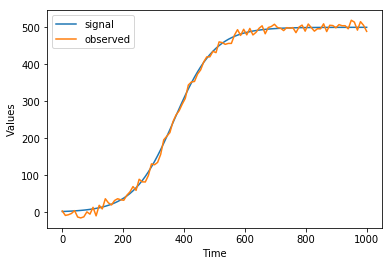

In [1]:
import os
os.chdir('/Users/appleuser/Desktop/AllPints/pints/')
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
r = 0.015
k = 500
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = signal_values + pints.noise.independent(sigma, signal_values.shape)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

Create the nested sampler that will be used to sample from the posterior.

In [2]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, sigma * 0.5],
    [0.02, 600, sigma * 1.5])

# Create a nested ellipsoidal rejectection sampler
sampler = pints.NestedRejectionSampler(log_likelihood, log_prior)

# Set number of iterations
sampler.set_iterations(1000)

# Set the number of posterior samples to generate
sampler.set_posterior_samples(100)

# Set the number of active points
sampler.set_active_points(400)

Run the sampler!

In [3]:
samples, marginal_log_likelihood = sampler.run()
print('Done!')

Running nested rejection sampling
Number of active points: 400
Total number of iterations: 1000
Total number of posterior samples: 100
Iter. Eval. Time m:s
0     1       0:00.0
0     2       0:00.0
0     3       0:00.0
0     4       0:00.0
0     5       0:00.0
0     21      0:00.0
0     41      0:00.0
0     61      0:00.0
0     81      0:00.0
0     101     0:00.0
0     121     0:00.1
0     141     0:00.1
0     161     0:00.1
0     181     0:00.1
0     201     0:00.1
0     221     0:00.1
0     241     0:00.1
0     261     0:00.1
0     281     0:00.1
0     301     0:00.1
0     321     0:00.1
0     341     0:00.2
0     361     0:00.2
0     381     0:00.2
400   401     0:00.2
420   425     0:00.2
440   451     0:00.2
460   479     0:00.2
480   509     0:00.2
500   553     0:00.3
520   603     0:00.3
540   653     0:00.3
560   691     0:00.3
580   749     0:00.3
600   805     0:00.4
620   851     0:00.4
640   913     0:00.4
660   981     0:00.4
680   1059    0:00.5
700   1139    0:00.5
720 

## Plot posterior samples versus true parameter values (dashed lines)

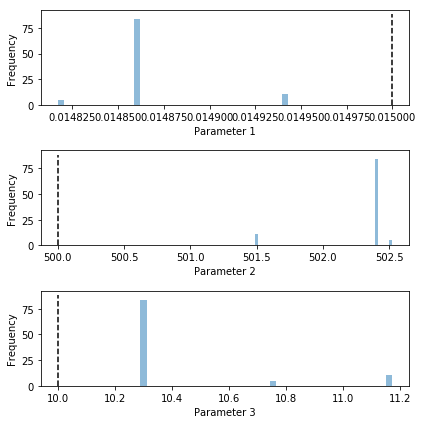

In [4]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=[r, k, sigma])

plt.show()

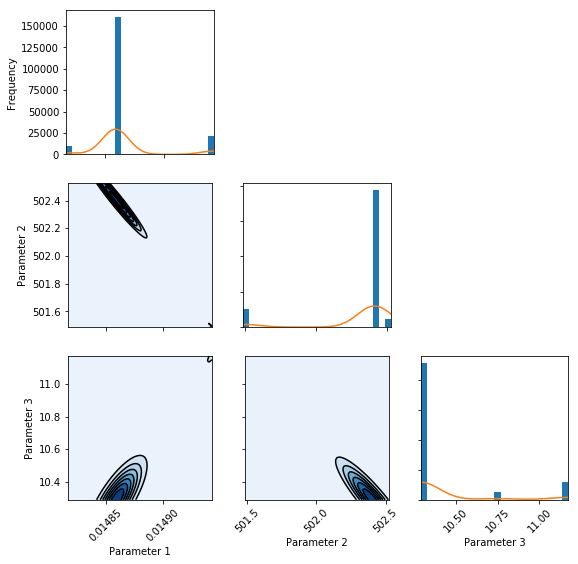

In [5]:
vTheta = samples[0]
pints.plot.pairwise(samples, kde=True)

plt.show()

## Plot posterior predictive simulations versus the observed data

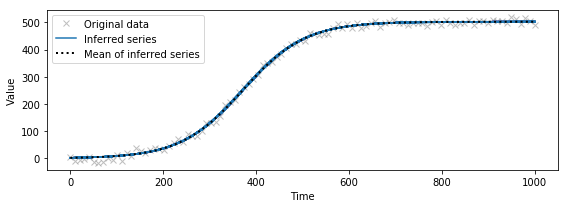

In [6]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate

In [7]:
print('marginal log-likelihood = ' + str(marginal_log_likelihood))

marginal log-likelihood = -372.064242245
